## RQ2 Analysis
This notebook contains the analysis for RQ2. The goal of this analysis is to understand the evolution of the serialization format used in the dataset over the years.

### Load the data

In [49]:
from scripts.notebooks.nb_utils import read_commits

# model files per repository and the elapsed days between the commit and safetensor's release date
df = read_commits()
df['year'] = df['date'].dt.year
df

,repo_url,commit_hash,model_file_path,serialization_format,message,author,date,elapsed_days,year
0,rinna/japanese-gpt-neox-small,f33d44540298e143079f34c35b21eebe4f3dce89,model.safetensors,safetensors,Adding `safetensors` variant of this model (#2...,Tianyu Zhao,2023-08-04 06:46:32,315,2023
1,rinna/japanese-gpt-neox-small,d93a6e4cfd29b7a4cccc068c24f4afab9c218c45,pytorch_model.bin,torch.save,* 2023/03/20 Update the model weight and confi...,Tianyu Zhao,2023-03-20 04:00:35,178,2023
2,rinna/japanese-gpt-neox-small,f3cdc9a0868ac3d6dbd8f7431f719dc07c5114e9,pytorch_model.bin,torch.save,init commit,Tianyu Zhao,2022-08-31 02:01:42,-23,2022
3,rinna/japanese-gpt-neox-small,f3cdc9a0868ac3d6dbd8f7431f719dc07c5114e9,spiece.model,ONNX,init commit,Tianyu Zhao,2022-08-31 02:01:42,-23,2022
4,Intel/roberta-base-squad2-int8-static-inc,79caea4b54eec88d1a75f641ecce4446aa8fd2a9,pytorch_model.bin,torch.save,upload int8 model.,"Lv, Kaokao",2022-08-30 05:25:59,-24,2022
...,...,...,...,...,...,...,...,...,...
8166,pyannote/segmentation,2ac9a3a5d497041fef00cbe9d8cf850f2733643c,pytorch_model.bin,torch.save,feat: initial import,Hervé Bredin,2021-03-31 10:34:50,-541,2021
8167,pyannote/segmentation,2ac9a3a5d497041fef00cbe9d8cf850f2733643c,tfevents.bin,undetermined,feat: initial import,Hervé Bredin,2021-03-31 10:34:50,-541,2021
8168,bigscience/T0pp,7df7b1c1aa361dd74049d0b794a01801fb4563de,model.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Christopher Akiki,2024-03-19 12:02:07,543,2024
8169,bigscience/T0pp,9ed7dc8f698fa88dcded8dcc4912aece2e4410fc,pytorch_model.bin,torch.save,model upload,VictorSanh,2021-10-12 15:25:07,-346,2021


### Visualization of serialization format over the years

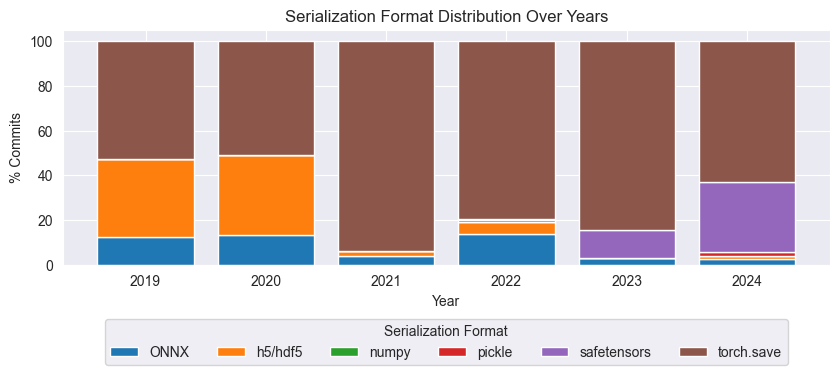

In [50]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt
import numpy as np
# Sample data
df = df[df['serialization_format'] != 'undetermined']
# Compute a slice of the DataFrame with the relevant columns
df_by_date = df[['year', 'serialization_format']]


# Group by year and serialization format, then count occurrences
grouped = df_by_date.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

# Cumulative values for stacked bars
cumulative_values = np.zeros(len(grouped_percentage))

for serialization_format in grouped_percentage.columns:
    ax.bar(grouped_percentage.index, grouped_percentage[serialization_format], 
           bottom=cumulative_values, label=serialization_format)
    cumulative_values += grouped_percentage[serialization_format]

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Distribution Over Years')
# ax.legend(title='Serialization Format')
# Move the legend outside of the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])


# save as pdf
plt.savefig(RESULTS_DIR/'RQ2ResultsStacked.pdf', format='pdf', bbox_inches='tight')
plt.show()


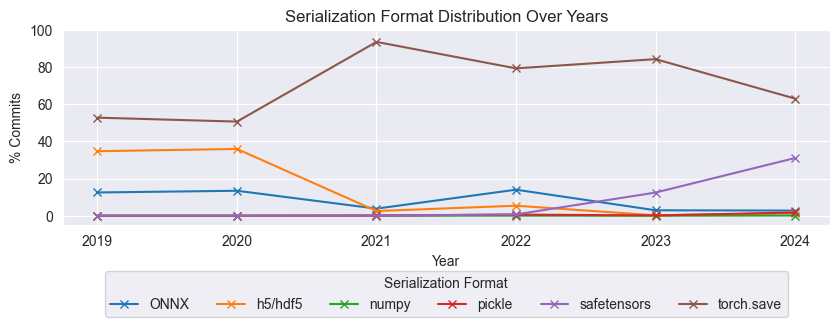

In [54]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt


# Group by year and serialization format, then count occurrences
grouped = df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 4)) 
# make y-axis range from 0 to 100
ax.set_ylim(-5, 100)

# Plot lines for each serialization format
for serialization_format in grouped_percentage.columns:
    ax.plot(grouped_percentage.index, grouped_percentage[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Distribution Over Years')
# ax.legend(title='Serialization Format')
# Move the legend outside of the plot
ax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 0.85, 1])  # Adjust the rectangle to fit the legend

# save as pdf
plt.savefig(RESULTS_DIR / 'RQ2ResultsDistribution.pdf', format='pdf', bbox_inches='tight')

plt.show()

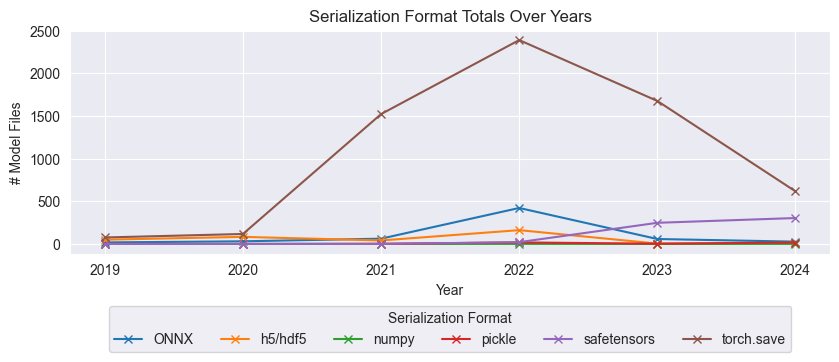

In [52]:
import matplotlib.pyplot as plt


# Filter out rows with 'undetermined' serialization format
filtered_df = df[df['serialization_format'] != 'undetermined']
# Group by year and serialization format, then count occurrences
grouped_counts = filtered_df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Set the size of the figure (width, height)
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust width and height as needed

# Plot the line chart with counts
for serialization_format in grouped_counts.columns:
    ax.plot(grouped_counts.index, grouped_counts[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('# Model Files')
ax.set_xlabel('Year')
ax.set_title('Serialization Format Totals Over Years')

# Move the legend outside of the plot
ax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.3, 0.85, 1])

plt.show()
